In [659]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [660]:
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [661]:
def load_dataset():
  column_names = [ 'id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating' ]
  data_path = '/content/drive/My Drive/data-nlp-humor-offense/train.csv'
  data_frame = pd.read_csv(data_path, names=column_names, skiprows=1, na_values="?", sep=",", skipinitialspace=True)
  data = data_frame.fillna(0).to_numpy()

  return data, data_frame

In [662]:
result, df_result = load_dataset()
print(result[:5])

[[1
  "TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit..."
  1 2.42 1.0 0.2]
 [2
  'A man inserted an advertisement in the classifieds "Wife Wanted". The next day, he received 1000 of replies, all reading: "You can have mine." Free delivery also available at your door step'
  1 2.5 1.0 1.1]
 [3
  'How many men does it take to open a can of beer? None. It should be open by the time she brings it to the couch.'
  1 1.95 0.0 2.4]
 [4
  "Told my mom I hit 1200 Twitter followers. She pointed out how my brother owns a house and I'm wanted by several collection agencies. Oh ma!"
  1 2.11 1.0 0.0]
 [5
  'Roses are dead. Love is fake. Weddings are basically funerals with cake.'
  1 2.78 0.0 0.1]]


In [663]:
print(df_result['is_humor'].value_counts())
print(df_result['humor_rating'].value_counts())
print(df_result['humor_controversy'].value_counts())
print(df_result['offense_rating'].value_counts())

1    4932
0    3068
Name: is_humor, dtype: int64
2.00    156
2.50    125
2.05    111
2.60    109
2.25    101
       ... 
3.13      1
0.47      1
2.57      1
3.74      1
0.30      1
Name: humor_rating, Length: 253, dtype: int64
0.0    2467
1.0    2465
Name: humor_controversy, dtype: int64
0.00    3388
0.15     394
0.05     387
0.10     333
0.20     306
        ... 
4.85       2
4.80       2
4.55       2
4.75       1
4.45       1
Name: offense_rating, Length: 98, dtype: int64


In [664]:
def format_text_to_one_hot(array_of_texts):
  vocabulary = []
  vocabulary_map = {}
  counter = 1
  end_result = []
  print()

  for text in array_of_texts:
    
    text_represented_with_numbers = []

    # break the text into sentences
    sentences = sent_tokenize(text)

    for sentence in sentences:

      # break the sentence into words
      words_array = word_tokenize(sentence)

      for word in words_array:

        # remove punctuation
        word = word.translate(str.maketrans('', '', string.punctuation))
        
        # lower case all letters 
        word = word.lower()

        if word != '' and word != 's':
          if not vocabulary.__contains__(word):
            vocabulary.append(word)
            vocabulary_map[word] = counter
            counter += 1
          
          text_represented_with_numbers.append(vocabulary_map[word])
  
    # add text to result array
    end_result.append(text_represented_with_numbers)
  
  # arrays to have same length
  padded_seq = pad_sequences(end_result, maxlen=63, dtype='int32', padding='pre', value=0.0)
  print(len(vocabulary))
  return padded_seq

In [665]:
# value = ["Something, this is an example. One!", "This is two!! Really, that's exactly what i though."]
# format_text_to_one_hot(value)

In [666]:
texts = df_result['text']
values = df_result['is_humor']
np.save('/tmp/values', values)
print(len(texts))
formatted_texts = format_text_to_one_hot(texts)
np.save('/tmp/formatted_texts', formatted_texts)
print(len(formatted_texts))

8000

15050
8000


In [667]:
train_data, train_labels = [], []
test_data, test_labels = [], []

humor_yes_data, humor_yes_labels = [], []
humor_no_data, humor_no_labels = [], []

for i in range(0, len(values)):
  if values[i] == 1:
    humor_yes_data.append(formatted_texts[i])
    humor_yes_labels.append(values[i])
  else:
    humor_no_data.append(formatted_texts[i])
    humor_no_labels.append(values[i])

yes_total = len(humor_yes_labels)
no_total = len(humor_no_data)
train_yes = int(0.75 * yes_total)
train_no = int(0.75 * no_total)

train_data_temp = np.concatenate((humor_yes_data[:train_yes], humor_no_data[:train_no]))
train_labels_temp = np.concatenate((humor_yes_labels[:train_yes], humor_no_labels[:train_no]))

test_data_temp = np.concatenate((humor_yes_data[train_yes:], humor_no_data[train_no:]))
test_labels_temp = np.concatenate((humor_yes_labels[train_yes:], humor_no_labels[train_no:]))

train_keys = []
test_keys = []
output_bias = np.log([len(humor_yes_data)/len(humor_no_data)])

result_train_map = {}
for index in range(0,len(train_data_temp)):
  result_train_map[index] = {'text': train_data_temp[index], 'label': train_labels_temp[index]}
  train_keys.append(index)

result_test_map = {}
for index in range(0, len(test_data_temp)):
  result_test_map[index] = {'text': test_data_temp[index], 'label': test_labels_temp[index]}
  test_keys.append(index)

random.shuffle(train_keys)
random.shuffle(test_keys)

for key in train_keys:
  train_data.append(result_train_map[key].get('text'))
  train_labels.append(result_train_map[key].get('label'))

for key in test_keys:
  test_data.append(result_test_map[key].get('text'))
  test_labels.append(result_test_map[key].get('label'))

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [668]:
example = {'text': 'example'}
print(example.get('text'))

example


In [669]:
#print(len(train_data))
#print(len(test_data))
np.save('/tmp/train_data', train_data)
np.save('/tmp/train_labels', train_labels)
np.save('/tmp/test_data', test_data)
np.save('/tmp/test_labels', test_labels)

In [670]:
init = tf.constant_initializer(output_bias)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=init, use_bias=True)
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto')

In [671]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
              #optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001, momentum=0.9),
              optimizer=tf.keras.optimizers.Adam(0.00005),
              metrics=['accuracy'])

In [672]:
x_data = train_data
x_data.astype(float)
y_data = train_labels
y_data.astype(float)

history = model.fit(x_data, y_data, epochs=100, validation_split=0.3, verbose=1, callbacks=callback)

Epoch 1/100
132/132 [==============================] - 1s 5ms/step - loss: 847.7995 - accuracy: 0.6209 - val_loss: 558.8354 - val_accuracy: 0.5900
Epoch 2/100
132/132 [==============================] - 0s 3ms/step - loss: 479.7878 - accuracy: 0.5715 - val_loss: 315.8762 - val_accuracy: 0.5728
Epoch 3/100
132/132 [==============================] - 0s 3ms/step - loss: 327.3005 - accuracy: 0.5543 - val_loss: 240.4530 - val_accuracy: 0.5594
Epoch 4/100
132/132 [==============================] - 0s 4ms/step - loss: 260.9354 - accuracy: 0.5406 - val_loss: 198.0158 - val_accuracy: 0.5522
Epoch 5/100
132/132 [==============================] - 0s 3ms/step - loss: 214.3562 - accuracy: 0.5276 - val_loss: 166.0196 - val_accuracy: 0.5461
Epoch 6/100
132/132 [==============================] - 0s 3ms/step - loss: 176.5910 - accuracy: 0.5431 - val_loss: 144.0651 - val_accuracy: 0.5478
Epoch 7/100
132/132 [==============================] - 0s 3ms/step - loss: 154.0397 - accuracy: 0.5509 - val_loss: 125

In [673]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=1)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 0s 2ms/step - loss: 2.5265 - accuracy: 0.6210
Test Loss: 2.526477575302124
Test Accuracy: 0.6209999918937683


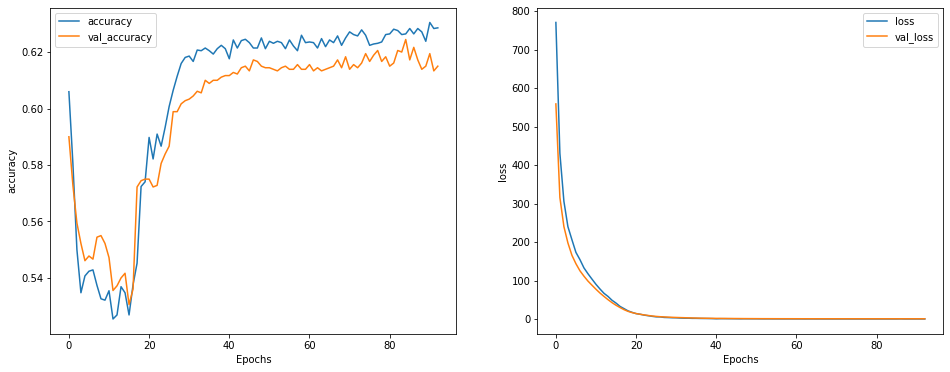

In [674]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [675]:
sample = format_text_to_one_hot(["What do you call a Frenchman wearing sandals? Philippe Philoppe.",
"Two whales walk into a bar. The first whale says to the other, 'WOOOOOO. WEEEEEEEEOOOOO. WEEEEEEEEEEEEOOOOOOOOO.' The second whale says, 'Shut up Steve, you're drunk.'",
"'Did you know it takes three sheep to make a sweater?' 'I didn't know sheep could knit.'", "This is not funny", "Hey", "example"])
sample_labels = [1, 1, 1, 0]

result = model.predict(sample)



48


In [676]:
print(result)

[[0.61749816]
 [0.6172117 ]
 [0.6173972 ]
 [0.6178993 ]
 [0.6177551 ]
 [0.6177627 ]]
